# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%ls "/content/drive/My Drive/ppk/images"

classed/  raw/  test_images.tfrecords  train_images.tfrecords


In [3]:
%cd /content

/content


In [4]:
%mkdir /content/images

In [5]:
# %cp -r "/content/drive/My Drive/ppk/." /content/
%cp -r "/content/drive/My Drive/ppk/images/raw" /content/images
%cp -r "/content/drive/My Drive/ppk/train.csv" /content/
%cp -r "/content/drive/My Drive/ppk/test.csv" /content/

In [4]:
%ls /content

drive/  images/  sample_data/  test.csv  train.csv


# Get dependencies

In [5]:
%load_ext tensorboard

In [6]:
import pandas as pd
import numpy as np 
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tqdm import tqdm


import matplotlib.pyplot as plt

import datetime

import os 
import glob

tqdm.pandas()

In [7]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [8]:
SEED = 2048

In [9]:
tf.random.set_seed(SEED)

# Get Labels

In [10]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [11]:
train.head(), test.head()

(  image_id  healthy  multiple_diseases  rust  scab
 0  Train_0        0                  0     0     1
 1  Train_1        0                  1     0     0
 2  Train_2        1                  0     0     0
 3  Train_3        0                  0     1     0
 4  Train_4        1                  0     0     0,   image_id
 0   Test_0
 1   Test_1
 2   Test_2
 3   Test_3
 4   Test_4)

In [12]:
def create_paths(image_id):
    return '/content/images/{}.jpg'.format(image_id)


train['path'] = train.image_id.progress_apply(create_paths)

100%|██████████| 1821/1821 [00:00<00:00, 330070.34it/s]


In [13]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab,path
0,Train_0,0,0,0,1,/content/images/Train_0.jpg
1,Train_1,0,1,0,0,/content/images/Train_1.jpg
2,Train_2,1,0,0,0,/content/images/Train_2.jpg
3,Train_3,0,0,1,0,/content/images/Train_3.jpg
4,Train_4,1,0,0,0,/content/images/Train_4.jpg


In [14]:
test['path'] = test.image_id.progress_apply(create_paths)

100%|██████████| 1821/1821 [00:00<00:00, 195505.86it/s]


In [15]:
test.head()

,image_id,path
0,Test_0,/content/images/Test_0.jpg
1,Test_1,/content/images/Test_1.jpg
2,Test_2,/content/images/Test_2.jpg
3,Test_3,/content/images/Test_3.jpg
4,Test_4,/content/images/Test_4.jpg


# Device initialization

## TPU

In [16]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.44.8.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.44.8.2:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


In [17]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## GPU

In [ ]:
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']

# get_available_gpus()

['/device:GPU:0']

# Make Datasets


In [18]:
train_paths, val_paths, train_labels, val_labels =  train_test_split(train.path.values, train.loc[:,train.columns[1:5]], test_size=0.2, random_state=SEED)

In [19]:
test_paths = test.path.values

In [20]:
image_size = 800
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync


In [21]:
def decode_image(filename, label=None, image_size=(image_size, image_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label


In [22]:
train_ds = (
      tf.data.Dataset
          .from_tensor_slices((train_paths, train_labels))
          .map(decode_image, num_parallel_calls=AUTO)
          .cache()
          .map(data_augment, num_parallel_calls=AUTO)
          .repeat()
          .shuffle(512)
          .batch(BATCH_SIZE)
          .prefetch(AUTO)
)
train_ds_1 = (
      tf.data.Dataset
          .from_tensor_slices((train_paths, train_labels))
          .map(decode_image, num_parallel_calls=AUTO)
          .cache()
          .map(data_augment, num_parallel_calls=AUTO)
          .repeat()
          .shuffle(512)
          .batch(64)
          .prefetch(AUTO)
)
val_ds = (
      tf.data.Dataset
          .from_tensor_slices((val_paths, val_labels))
          .map(decode_image, num_parallel_calls=AUTO)
          .batch(BATCH_SIZE)
          .cache()
          .prefetch(AUTO)
)

test_ds = (
      tf.data.Dataset
          .from_tensor_slices(test_paths)
          .map(decode_image, num_parallel_calls=AUTO)
          .map(data_augment, num_parallel_calls=AUTO)
          .batch(BATCH_SIZE)
)

# Build Our Model

In [23]:
def create_model():
  return tf.keras.models.Sequential([
        
        tf.keras.applications.InceptionResNetV2(
            input_shape=(image_size, image_size, 3),
            weights='imagenet',
            include_top=False
        ),
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

In [24]:
optimizer_ = tf.keras.optimizers.Adamax(1.0e-3)

In [25]:
with strategy.scope(): 
  model = create_model()
  # model.build(input_shape=(None, image_size, image_size, 3))
  model.summary()

  model.compile(optimizer=optimizer_,
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy']
                 )


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 23, 23, 1536)      54336736  
_________________________________________________________________
global_max_pooling2d (Global (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 6148      
Total params: 54,342,884
Trainable params: 54,282,340
Non-trainable params: 60,544
_________________________________________________________________


In [26]:
EPOCHS = 100

In [27]:
stop = tf.keras.callbacks.EarlyStopping(patience=15,
                                        monitor='val_loss')

# Train Model

In [28]:
history = model.fit(train_ds, 
                  epochs=EPOCHS,
                  validation_data=val_ds,
                  validation_batch_size=BATCH_SIZE,
                  steps_per_epoch=32, 
                  shuffle=True, 
                  max_queue_size=16, 
                  workers=16, 
                  use_multiprocessing=True,
                  callbacks=[stop],
                  verbose=1,
                  )

Epoch 1/100


UnimplementedError: ignored

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.ylim(0, 1.05)
plt.plot(hist.epoch, 
         hist.val_categorical_accuracy, 
         label="Validation Acccuracy")
plt.plot(hist.epoch, 
         hist.categorical_accuracy, 
         label="Train Accuracy")
plt.legend(loc='lower left',
           ncol=2,
           frameon=False)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(hist.epoch, 
         hist.val_loss, 
         label="Validation Loss")
plt.plot(hist.epoch, 
         hist.loss, 
         label="Train Loss")
plt.legend(loc='upper right',
           ncol=2,
           frameon=False)
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
%tensorboard --logdir logs/fit

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2020-07-19 01:31:32.670890: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/main.py", line 75, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.6/dist-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.6/dist-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/program.py", line 290, in main
    return runner(self.flags) or 0
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/program.py", line 306, in _run_serve_subcommand
    server = self._make_server()
  File "/usr/local/lib/python3

In [ ]:
label_array = train.columns[1::]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


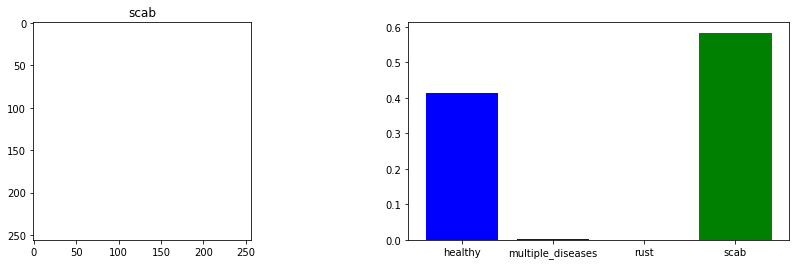

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


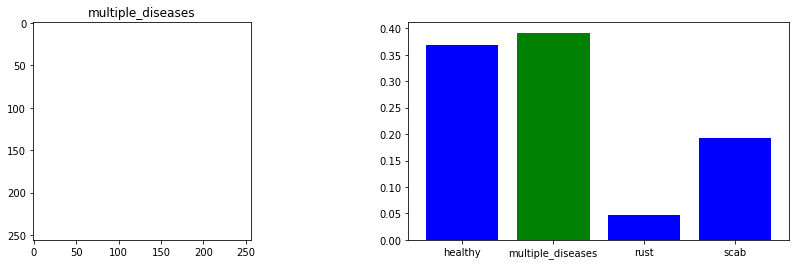

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


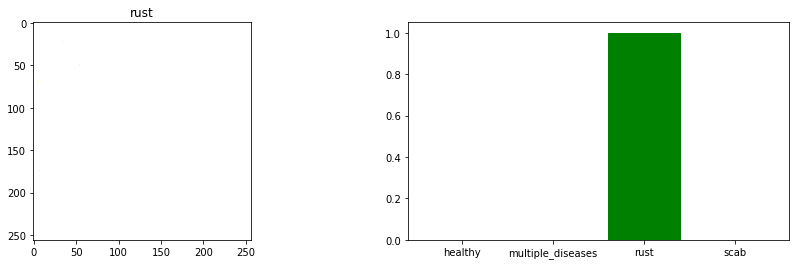

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


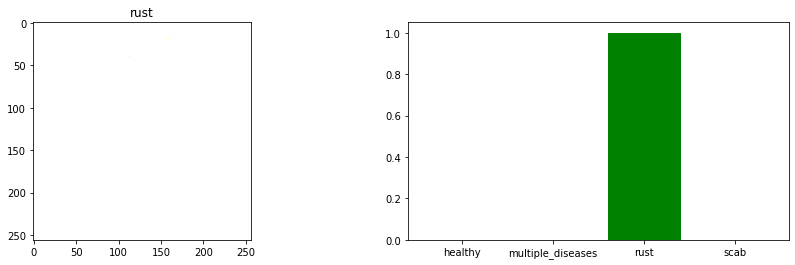

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


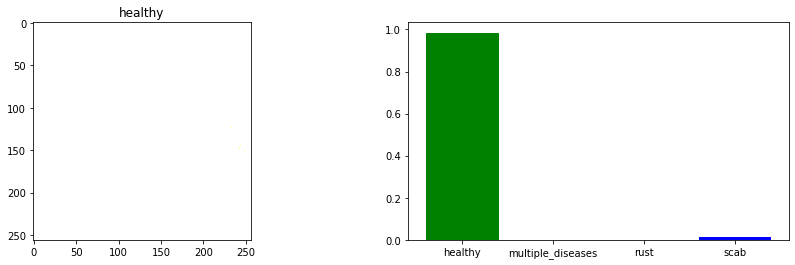

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


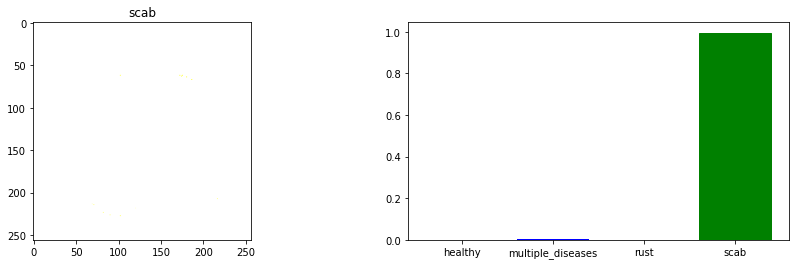

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


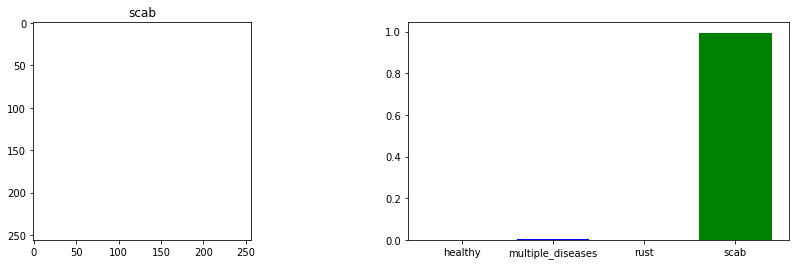

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


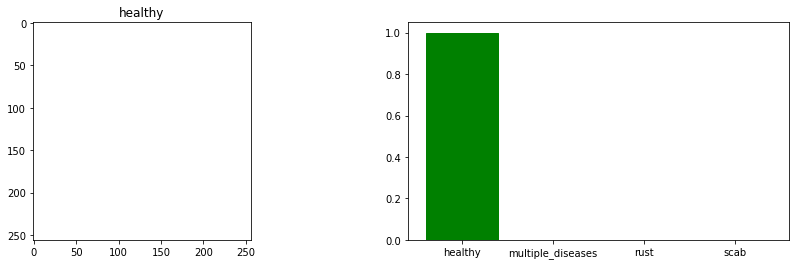

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


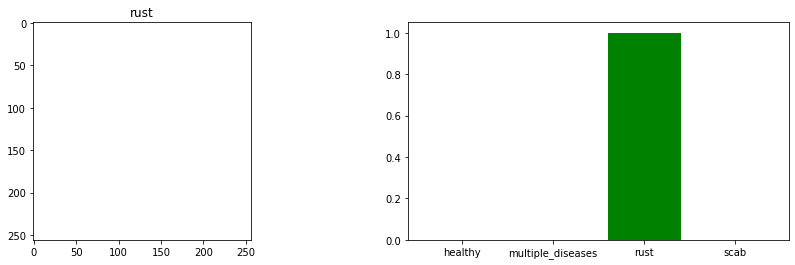

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


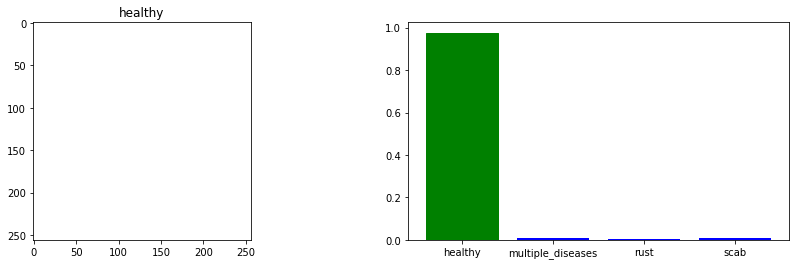

In [ ]:
label_array = train.columns[1::]
# plot_imgs = val_images.copy()
tru_train = y_test.values
counter = 0
for i, label in val_ds:
    if counter <= 9:
        # index = np.random.randint(low=0, high=len(plot_imgs), size=1)
        # img_predicted_on = plot_imgs[index][0]
        # full_img_path = test_df.path.values[index]
        # full_img_path = full_img_path[0].split('.')[0] + '.jpg'
        # img = cv2.imread(full_img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pred_array = model.predict(i)
        pred_class = label_array[np.argmax(pred_array[0])]
        
        tru_class = label_array[np.argmax(label)]
    #     if tru_class in ['healthy','rust']:
    #         continue
        f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        if pred_class == tru_class:
            pred_color = 'g'
            tru_color = 'g'
        else:
            pred_color = 'r'
            tru_color = 'g'
            
        ax[0].imshow(i[0])
        ax[0].set_title('{}'.format(tru_class))
        bar = ax[1].bar(label_array, pred_array[0], color='b')
        bar[np.argmax(pred_array[0])].set_color(pred_color)
        bar[np.argmax(label)].set_color(tru_color)
        counter += 1
        plt.show()
    else:
      break

# counter = 0
# for i, label in valGen_:
#   if counter <= 9:
#     print(i[0].shape)
#     counter +=1 
#   else:
#     break

In [ ]:
# import seaborn as sns
# confustion = tf.math.confusion_matrix(tru_train, predictions, num_classes=4)
# plt.figure(figsize=(15,15))
# sns.heatmap(confusion, annot=True)

In [ ]:
model.save('saved_model/newestModel_local')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/newestModel_local/assets


In [ ]:
!cp -r saved_model/newestModel_local/ "/content/drive/My Drive/ppk/saved_model/newestModel_local"

# Test model on new data

In [ ]:
test_df = pd.read_csv('test.csv')
test_df['path'] = test_df.image_id.progress_apply(create_paths)
test_df.path.values[:5]

In [ ]:
for i,d in enumerate(test_df.path.values[:25]):
    img = cv2.imread(d)
    # img = cv2.resize(img, (512,512))
    # img = img / 255
    # img = channel_norm(img).astype('float32') 
    # img = np.array(img)
    # img[:,:,0] -= blue_mean 
    # img[:,:,1] -= green_mean 
    # img[:,:,2] -= red_mean 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pred = np.expand_dims(img, 0)
    pred = model.predict(img_pred)
    pred = label_array[np.argmax(pred)]
    if pred == 'rust':
        continue
    plt.imshow(img)
    plt.show()

    print('='*25,pred,'='*25)
    full_im = cv2.imread(d)
    full_im = cv2.cvtColor(full_im, cv2.COLOR_BGR2RGB)
    plt.imshow(full_im)
    plt.show()

